In [1]:
import torch as th
import torch.nn as nn
import torch.optim as optim

from src.model import VAE
from src.trainer import Trainer

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

print('device is', device)

device is cuda


In [2]:
VAE_CFG = {
    # (in_ch, out_ch, kernel, stride, padding)
    'en_cnn_arch' : [
        # shape(*, 1, 28, 28)
        (1, 32, 3, 2, 1),   # shape(∗, 32, 14, 14)
        (32, 64, 3, 2, 1),  # shape(∗, 64, 7, 7)
        (64, 64, 3, 2, 1),  # shape(∗, 64, 4, 4)
    ],
    'en_fc_arch' : [
        64 * 4 * 4,
        20
    ],
    'de_fc_arch' : [
        20,
        64 * 4 * 4,
    ],
    'de_cnn_in_shape' : (64, 4, 4),
    # (in_ch, out_ch, kernel, stride, padding, output_padding)
    'de_cnn_arch' : [
        # shape(*, 64, 4, 4)
        (64, 64, 3, 2, 1, 0),   # shape(∗, 64, 7, 7)
        (64, 32, 3, 2, 1, 1),   # shape(∗, 32, 14, 14)
        (32, 1, 3, 2, 1, 1),    # shape(∗, 1, 14, 14)
    ],
    'activ_fn' : nn.ReLU
}

BATCH_SIZE = 256
LR = 0.003
N_WORKERS = 4

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

dataset = datasets.MNIST(
    root='torch_dataset',
    train=True,
    download=True,
    transform=ToTensor()
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=N_WORKERS)

vae = VAE(**VAE_CFG)
vae.to(device)
optimizer = optim.Adam(params=vae.parameters(),lr=LR)

In [4]:
trainer = Trainer(vae, optimizer, dataloader, device)
trainer.train(
    n_epoch=20,
    log_freq=30,
    directory='./mnist_models'
)

| epoch 0/20 | batch 29/234 | recon loss 75.534 | regul loss 1.170879 |
| epoch 0/20 | batch 59/234 | recon loss 53.859 | regul loss 1.273691 |
| epoch 0/20 | batch 89/234 | recon loss 49.669 | regul loss 1.947304 |
| epoch 0/20 | batch 119/234 | recon loss 44.587 | regul loss 3.461538 |
| epoch 0/20 | batch 149/234 | recon loss 39.144 | regul loss 5.444269 |
| epoch 0/20 | batch 179/234 | recon loss 35.454 | regul loss 6.582055 |
| epoch 0/20 | batch 209/234 | recon loss 32.678 | regul loss 7.314815 |
| epoch 1/20 | batch 29/234 | recon loss 29.561 | regul loss 8.320621 |
| epoch 1/20 | batch 59/234 | recon loss 28.015 | regul loss 8.893981 |
| epoch 1/20 | batch 89/234 | recon loss 27.180 | regul loss 9.184838 |
| epoch 1/20 | batch 119/234 | recon loss 26.121 | regul loss 9.511006 |
| epoch 1/20 | batch 149/234 | recon loss 25.258 | regul loss 9.659982 |
| epoch 1/20 | batch 179/234 | recon loss 24.655 | regul loss 9.898742 |
| epoch 1/20 | batch 209/234 | recon loss 24.278 | regul 

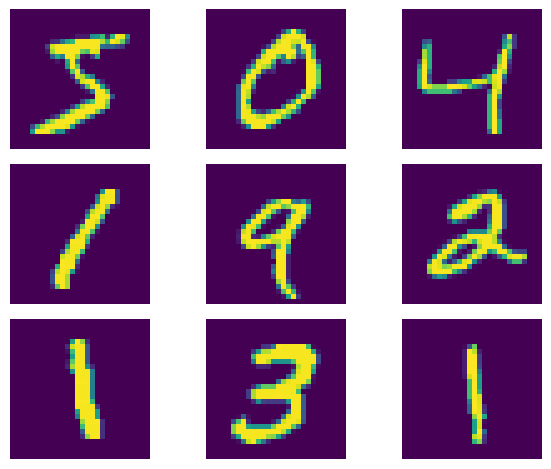

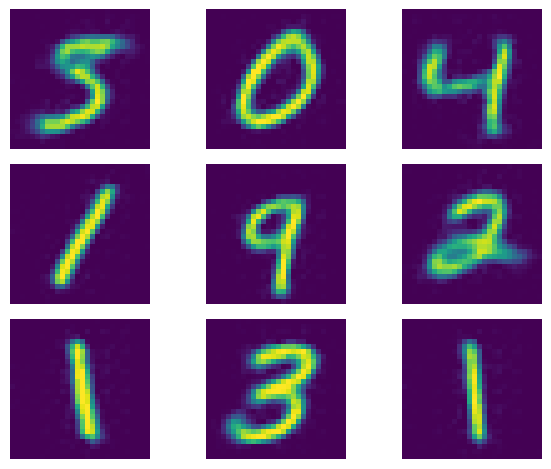

In [11]:
from src.utils import display_image

x = th.stack([dataset[k][0] for k in range(9)], dim=0).to(device)

with th.no_grad() :
    z,_ = vae.encode(x)
    y = vae.decode(z).clip(0.0,1.0)

display_image(img=x.to('cpu'), grid_shape=(3,3))
display_image(img=y.to('cpu'), grid_shape=(3,3))

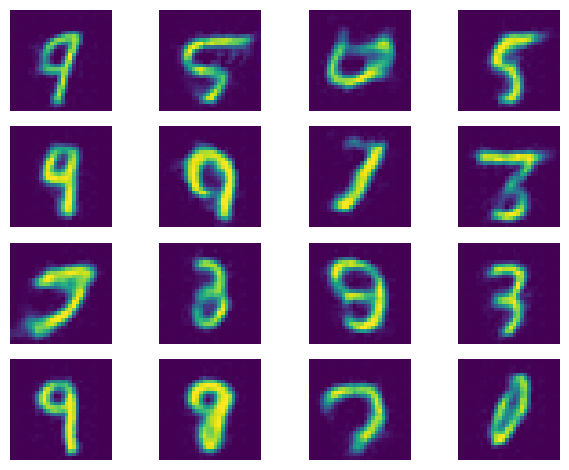

In [14]:
from src.utils import display_image

latent_space = VAE_CFG['en_fc_arch'][-1]
z = th.randn(16, latent_space, device=device)

with th.no_grad():
    y = vae.decode(z).clip(0.0,1.0)

display_image(img=y.to('cpu'), grid_shape=(4,4))